In [1]:
# Install LSDB
%pip install -U lsdb
# Install other deps
%pip install -U light_curve[full] matplotlib

In [2]:
import light_curve as licu
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client
from nested_dask import NestedFrame
from lsdb import read_hipscat, Catalog

In [3]:
# Helper functions

from __future__ import annotations

def pack_lists(
        catalog: Catalog,
        base_columns: list[str] | None,
        list_columns: list[str] | None = None,
        name: str = 'nested',
):
    """Pack list-columns into nested columns
    
    Margin cache support is not implemented
    """
    new_ddf = NestedFrame.from_lists(
        catalog._ddf,
        base_columns=base_columns,
        list_columns=list_columns,
        name=name,
    )
    return Catalog(new_ddf, catalog._ddf_pixel_map, catalog.hc_structure)


def plot_lc(lc, title=None):
    for fid, band in zip([1, 2], 'gr'):
        idx = lc['lc_fid'] == fid
        plt.scatter(lc['lc_mjd'][idx], lc['lc_magpsf'][idx], label=band, color=band, marker='x', s=10)
        plt.errorbar(lc['lc_mjd'][idx], lc['lc_magpsf'][idx], lc['lc_sigmapsf'][idx], color=band, ls='')
    plt.legend()
    plt.title(title)
    plt.xlabel('MJD')
    plt.ylabel('mag')
    plt.gca().invert_yaxis()

In [4]:
# Path on Epyc
ALERCE_SAMPLE_PATH = '/data3/epyc/data3/hipscat/test_catalogs/alerce/alerce_nested'

# Load catalog with nested lists
raw_catalog = read_hipscat(
    ALERCE_SAMPLE_PATH,
)

# Pack all list-columns together
catalog_with_lc = pack_lists(
    raw_catalog,
    base_columns=[col for col in raw_catalog.columns if not col.startswith('lc_')],
    name='lc',
)

catalog_with_nondet = pack_lists(
    catalog_with_lc,
    base_columns=[col for col in catalog_with_lc.columns if not col.startswith('nondet_')],
    name='nondet',
)

catalog = pack_lists(
    catalog_with_nondet,
    base_columns=[col for col in catalog_with_nondet.columns if not col.startswith('ref_')],
    name='ref',
)

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44856 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:44856/status,
Dashboard: http://127.0.0.1:44856/status,Workers: 1
Total threads: 96,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34489,Workers: 1
Dashboard: http://127.0.0.1:44856/status,Total threads: 96
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:37891,Total threads: 96
Dashboard: http://127.0.0.1:39044/status,Memory: 0.98 TiB
Nanny: tcp://127.0.0.1:44845,


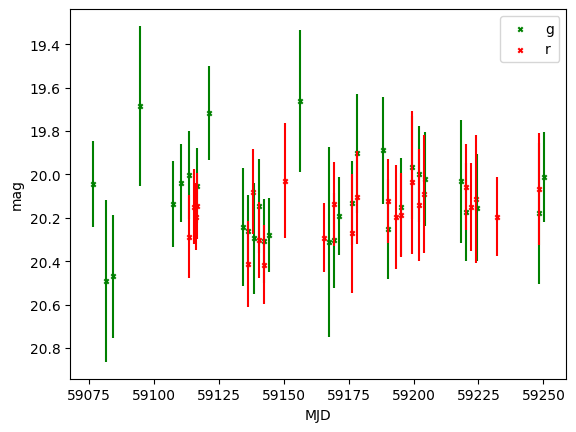

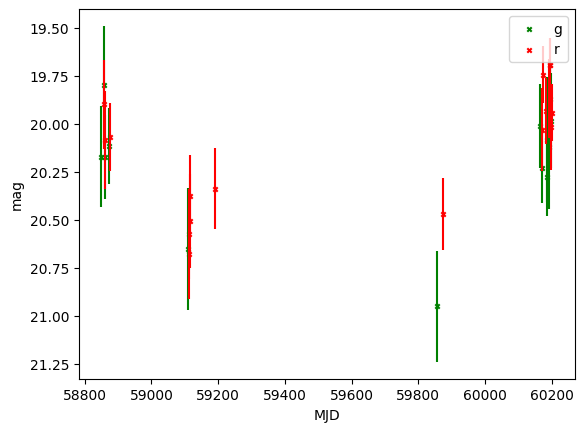

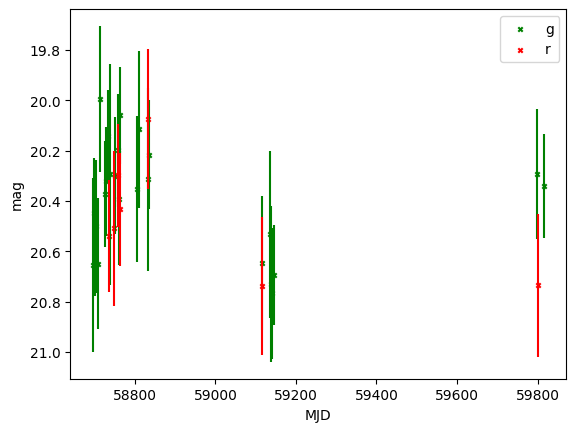

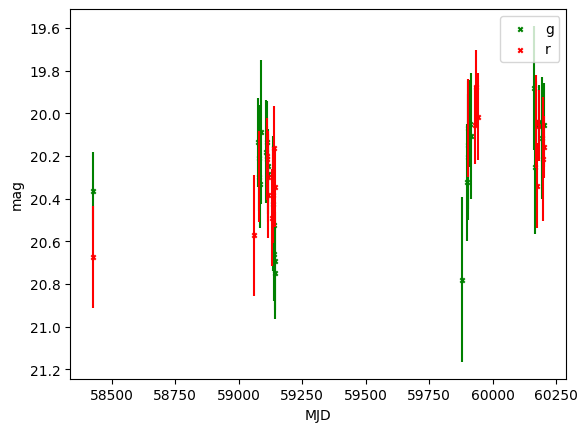

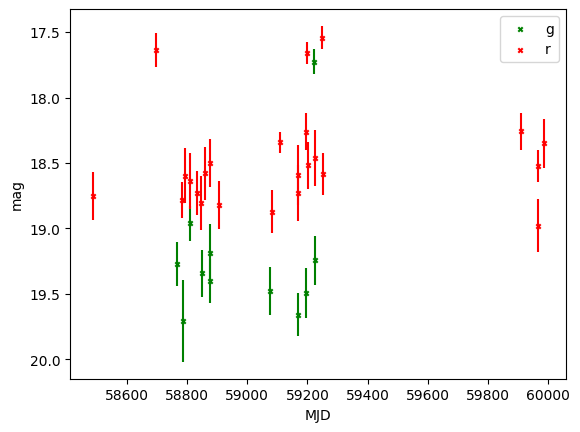

In [5]:
# "Compute" the first partition and plot few light curves

# Single partition would require single worker
with Client(n_workers=1) as client:
    display(client)
    ndf = catalog.partitions[0].compute()

for lc in ndf['lc'].iloc[:5]:
    plt.figure()
    plot_lc(lc)

In [6]:
# Let's try to find a fine SN in this data

feature_extractor = licu.Extractor(
    licu.BazinFit(algorithm='ceres', ceres_niter=20, ceres_loss_reg=3),
    licu.ObservationCount(),
    licu.ReducedChi2(),
)


def extract_features(t, m, sigma):
    # Convert magnitude to fluxes    
    flux = 10**(-0.4 * (m - 8.9))
    flux_err = 0.4 * np.log(10) * sigma * flux
    
    # Sort time and remove duplicated, required by light-curve package
    _, idx = np.unique(t, return_index=True)
    
    values = feature_extractor(t[idx], flux[idx], flux_err[idx], fill_value=np.nan)
    return dict(zip(feature_extractor.names, values))


# Use r-band only and drop missed data
r_band = catalog_with_lc._ddf.query('lc.lc_fid == 2')
# Remove missed data
r_band_no_missing = r_band.dropna(subset=['lc.lc_sigmapsf']).dropna(subset=['lc'])

# Extract features, Catalog.reduce is still WIP, so we use underlying dataframe directly
# https://github.com/astronomy-commons/lsdb/pull/414
features = r_band_no_missing.reduce(
    extract_features,  # function
    'lc.lc_mjd', 'lc.lc_magpsf', 'lc.lc_sigmapsf',  # columns to use
    meta=dict.fromkeys(feature_extractor.names, float) # Dask meta
)

# Filter features to get nice light-curves
nice_features = features.query(
    'bazin_fit_reduced_chi2 > 0.8 and bazin_fit_reduced_chi2 < 3.0'
    ' and bazin_fit_rise_time > 3 and bazin_fit_rise_time < 10'
    ' and bazin_fit_fall_time < 30 and bazin_fit_fall_time > 10'
    ' and observation_count >= 10'
    ' and chi2 > 5.0'
)

In [7]:
# Join features back to the main table
sn_candidates = catalog_with_lc._ddf.join(nice_features, how='inner')

In [8]:
%%time

# I'm not sure what should be the right configuration here, but this works fine on Epyc
with Client(n_workers=10, memory_limit="10GB", threads_per_worker=2) as client:
    display(client)
    ndf = sn_candidates.compute()

ndf

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36457 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36457/status,
Dashboard: http://127.0.0.1:36457/status,Workers: 10
Total threads: 20,Total memory: 93.13 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37999,Workers: 10
Dashboard: http://127.0.0.1:36457/status,Total threads: 20
Started: Just now,Total memory: 93.13 GiB
Comm: tcp://127.0.0.1:44561,Total threads: 2
Dashboard: http://127.0.0.1:37977/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:36332,


CPU times: user 1min 40s, sys: 31 s, total: 2min 11s
Wall time: 6min 49s


,oid,mean_ra,mean_dec,nondet_mjd,nondet_fid,nondet_diffmaglim,ref_rfid,ref_candid,ref_fid,ref_rcid,...,Npix,lc,bazin_fit_amplitude,bazin_fit_baseline,bazin_fit_reference_time,bazin_fit_rise_time,bazin_fit_fall_time,bazin_fit_reduced_chi2,observation_count,chi2
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
9623428969529344,ZTF20abwzqzo,41.513817,3.329906,[59062.3988426 59063.4427546 59064.4982292 590...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[18.9327 19.2845 19.2703 19.1208 20.4236 20.63...,[452120223 452120123],[1333447212315015004 1333483532315015005],[2 1],[23 23],...,0,lc_ra lc_dec lc_candid ...,0.000408,0.000030,59100.573583,3.111346,11.490058,0.879535,28.0,56.120445
12812266877485056,ZTF22abmxzxm,42.60675,5.793783,[59840.4067477 59840.4876273 59842.4434491 598...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2],[20.4905 20.5716 20.2987 20.5322 20.5446 20.58...,[452120233 452120133],[2111382493315015009 2113294083315015006],[2 1],[33 33],...,0,lc_ra lc_dec lc_candid ...,0.000363,0.000032,59870.560379,3.061167,20.848320,1.679472,13.0,36.492215
43742791112589312,ZTF21abvdazf,41.059097,10.256258,[59424.4553588 59429.4457755 59435.4333681 594...,[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2],[19.567 20.302 20.4668 20.4168 20.3161 19.07...,[505120231 505120131],[1697473413115015011 1705442483115015015],[2 1],[31 31],...,0,lc_ra lc_dec lc_candid ...,0.000111,0.000005,59455.898052,5.144836,24.962658,1.132158,14.0,11.381434
63387948371935232,ZTF20acqlfwb,42.891443,13.021577,[59140.4103241 59142.4055208 59144.38125 591...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2...,[20.5699 20.9406 21.016 18.882 19.6522 19.20...,[505120240 505120140],[1413317324015015032 1415321794015015037],[2 1],[40 40],...,0,lc_ra lc_dec lc_candid ...,0.000187,0.000003,59174.930188,3.182938,21.147838,0.898472,20.0,26.000655
119036040353677312,ZTF22abfyzir,48.358801,19.789209,[59811.4686921 59812.4357176 59814.4280208 598...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[20.1277 20.5114 20.4807 20.6399 20.7408 20.68...,[557120146 556120135 556120235 557120246],[2085339474615015001 2086427463515015003 20883...,[1 1 2 2],[46 35 35 46],...,0,lc_ra lc_dec lc_candid ...,0.000369,0.000006,59844.007861,3.360073,23.618371,0.888075,44.0,72.378785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13792177189740871680,ZTF22abbausm,318.621236,-9.047612,[59780.385787 59782.3140046 59784.3561806 597...,[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2...,[20.0083 20.3366 20.6899 20.1551 20.3456 20.56...,[389120234 389120134],[2055307343415015003 2055370943415015002],[2 1],[34 34],...,11,lc_ra lc_dec lc_candid ...,0.000873,0.000007,59815.424716,3.664686,27.214244,1.646161,26.0,144.653164
13796345153687912448,ZTF22aaynpda,321.732295,-7.016983,[59764.4182639 59766.4154051 59769.4392824 597...,[1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2],[20.7377 20.6621 20.6091 19.9463 19.93 20.29...,[390120258 390120158],[2040337975815015002 2046358695815015001],[2 1],[58 58],...,11,lc_ra lc_dec lc_candid ...,0.001689,0.000030,59805.238801,3.632095,25.991767,1.706844,31.0,306.649569
13798473228160598016,ZTF22abmcezf,319.982093,-6.437505,[59838.1497801 59841.2110648 59841.2624306 598...,[1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2],[20.0547 20.3394 20.3552 20.2929 20.3989 20.28...,[390120161 390120261],[2107190026115015007 2112175636115015005],[1 2],[61 61],...,11,lc_ra lc_dec lc_candid ...,0.000580,-0.000044,59866.010056,3.728221,28.085254,0.890226,17.0,46.556925


https://alerce.online/object/ZTF20abwzqzo
https://alerce.online/object/ZTF22abmxzxm
https://alerce.online/object/ZTF21abvdazf
https://alerce.online/object/ZTF20acqlfwb
https://alerce.online/object/ZTF22abfyzir


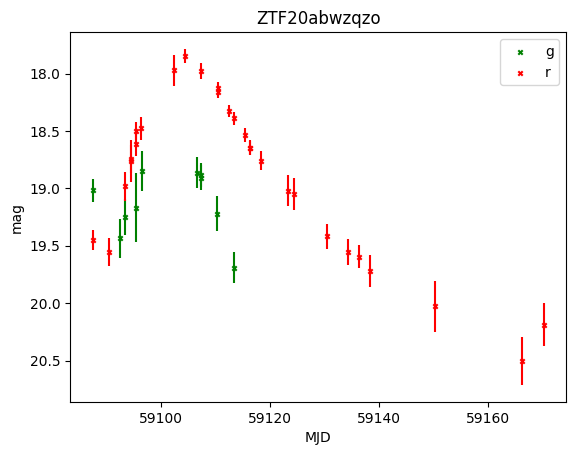

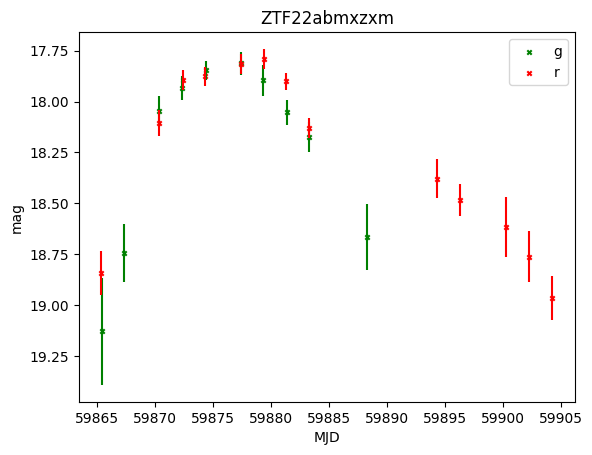

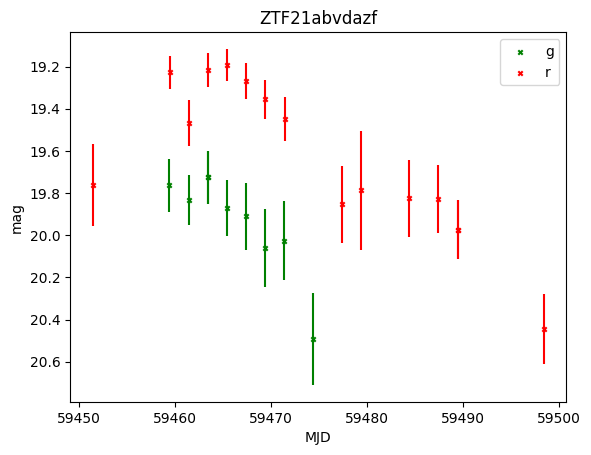

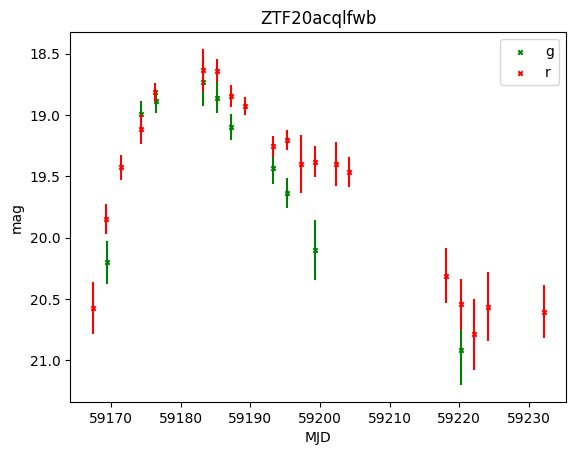

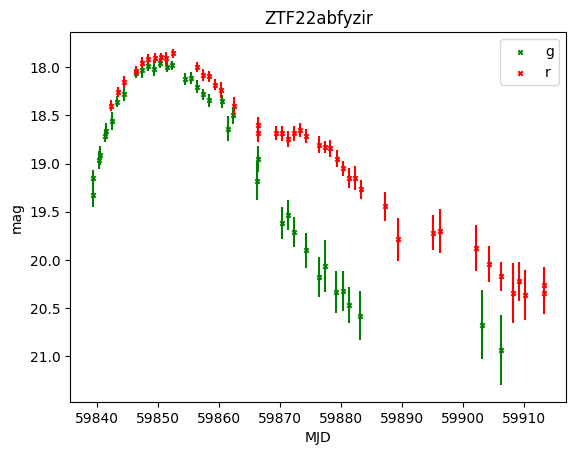

In [9]:
# Plot first five light curves

head = ndf.head(5)

for oid, lc in head[['oid', 'lc']].itertuples(index=False):
    plt.figure()
    plot_lc(lc, title=oid)
    print(f'https://alerce.online/object/{oid}')